In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


# Data Cleaning and Preprocessing 



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import joblib

import warnings
warnings.filterwarnings('ignore')


## Step 1: Load and Explore the Raw Data
We first load the dataset and check the basic statistics and missing values.


In [3]:
# Load
raw_df = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')
df = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')

# Explore
print(df.shape)
print(df.dtypes)
print(df.isnull().mean().sort_values(ascending=False))


(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64


## Step 2: Visualize Missing Values
We plot the missing value heatmap to visually see where missingness exists.


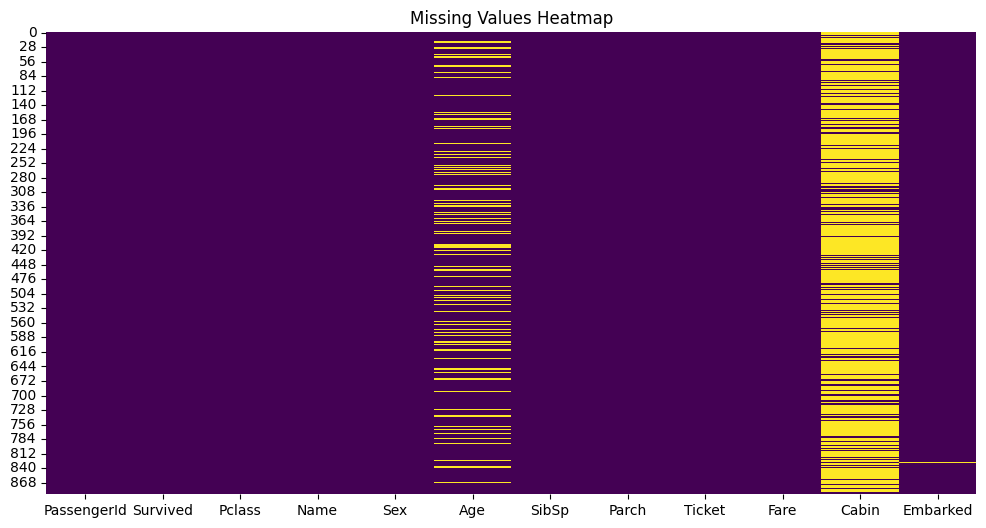

In [4]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

## Step 3: Clean the Data 
We drop columns with excessive missing values and impute missing values.


In [5]:
# Drop columns with too much missing data
missing_threshold = 0.4  # if more than 40% missing
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]
df.drop(columns=cols_to_drop, inplace=True)

# Separate numerical and categorical
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

# Imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_features] = num_imputer.fit_transform(df[num_features])
df[cat_features] = cat_imputer.fit_transform(df[cat_features])


## Step 4: Encode Categorical Variables
We encode binary categorical features with LabelEncoder and nominal features with One-Hot Encoding.


In [6]:
# Label Encoding
binary_cols = ['Sex']
for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# One-hot Encoding for 'Embarked'
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)


## Step 5: Scale Numerical Features (RobustScaler)
Scaling features to handle outliers better using RobustScaler.


In [7]:
scaler = RobustScaler()
scale_cols = ['Age', 'Fare']

df[scale_cols] = scaler.fit_transform(df[scale_cols])

# Save the scaler for future inference
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

## Step 6: Outlier Detection and Removal (Isolation Forest)
Using machine learning to detect and remove outliers automatically.


In [8]:
# Detect outliers
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df[scale_cols])

# -1 indicates outlier
df['outlier'] = outliers

# Keep only non-outliers
df = df[df['outlier'] != -1]

# Drop the helper column
df.drop('outlier', axis=1, inplace=True)

print(f"Data shape after outlier removal: {df.shape}")


Data shape after outlier removal: (846, 12)


## Step 7: Save Cleaned Dataset
We save the cleaned data to a new CSV file for further modeling.


In [9]:
# Save cleaned dataset
df.to_csv('cleaned_titanic.csv', index=False)

## Step 8: Compare Raw vs Cleaned Dataset
Let's check how the dataset improved after cleaning.


In [10]:
print("Before Cleaning:")
raw_df.describe()

Before Cleaning:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
print("\nAfter Cleaning:")
df.describe()


After Cleaning:


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,444.222222,0.371158,2.369976,0.654846,0.066080,0.516548,0.352246,0.432145
std,258.001280,0.483401,0.804718,0.475700,0.932996,1.102589,0.785242,1.102545
min,1.000000,0.000000,1.000000,0.000000,-2.121538,0.000000,0.000000,-0.626005
25%,219.250000,0.000000,2.000000,0.000000,-0.461538,0.000000,0.000000,-0.284041
50%,446.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,-0.062981
75%,664.750000,1.000000,3.000000,1.000000,0.461538,1.000000,0.000000,0.582331
max,891.000000,1.000000,3.000000,1.000000,2.923077,8.000000,6.000000,5.937556


## Step 9: Correlation Analysis
We visualize feature correlations to understand relationships.


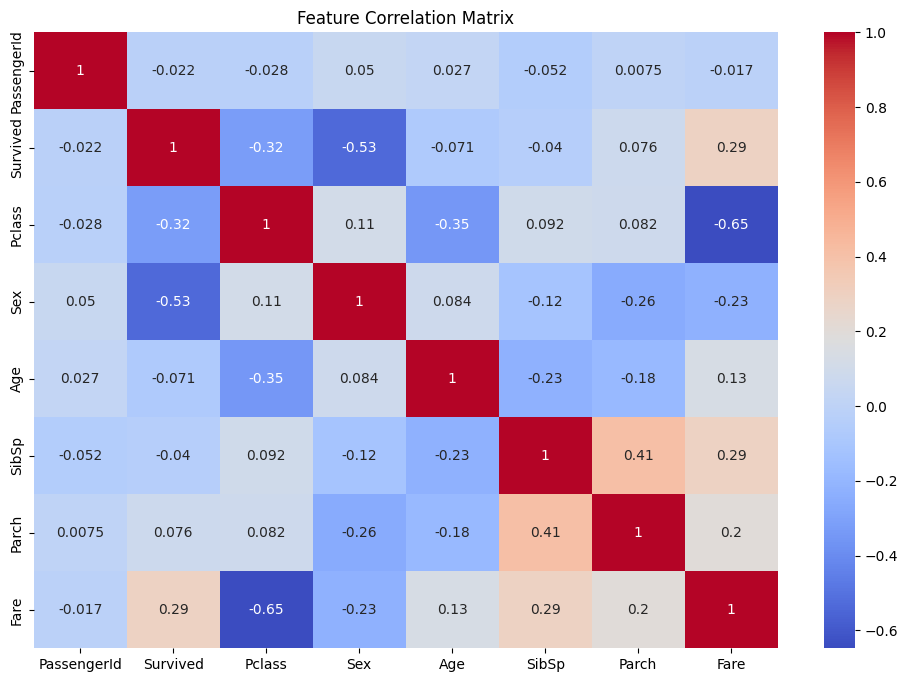

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
